In [1]:
# Import statements
import glob
import os
import tempfile
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from datetime import timedelta

from math import atan2 as atan2
from datetime import datetime

from metpy.plots import USCOUNTIES
from metpy.calc import dewpoint_from_relative_humidity
from metpy.units import units
from matplotlib.dates import DateFormatter, date2num
import imageio
import pyart
import nexradaws

import sage_data_client

templocation = tempfile.mkdtemp()

import os

import matplotlib.pyplot as plt

import act

import math

warnings.filterwarnings("ignore")
from windrose import WindroseAxes
import matplotlib.cm as cm
import netCDF4 as nc


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
## Additional import statements
import sage_data_client
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import netCDF4 as nc

from windrose import WindroseAxes
from matplotlib.dates import DateFormatter

In [3]:
## NEIU AQT 
df_aq = sage_data_client.query(start = "2023-06-26" + 'T' + "00:00:00" + 'Z',
                               end = "2023-07-01" + 'T' + "00:00:00" + 'Z', 
                               filter={
                                        "plugin": "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
                                       }
)
# extract the particle measurements from the DataFrame
pm25 = df_aq[df_aq['name']=='aqt.particle.pm2.5']
pm10 = df_aq[df_aq['name']=='aqt.particle.pm1']
pm100 = df_aq[df_aq['name']=='aqt.particle.pm10']

# extract the gas measurements from the DataFrame
no = df_aq[df_aq['name']=='aqt.gas.no']
o3 = df_aq[df_aq['name']=='aqt.gas.ozone']
no2 = df_aq[df_aq['name']=='aqt.gas.no2']
co = df_aq[df_aq['name']=='aqt.gas.co']

# extract the environment data from the DataFrame
aqtemp = df_aq[df_aq['name']=='aqt.env.temp']
aqhum = df_aq[df_aq['name']=='aqt.env.humidity']

# Convert values to numpy arrays
aqvals = pm25.set_index('timestamp')
aqvals['pm2.5'] = aqvals.value.to_numpy().astype(float)
aqvals['pm1.0'] = pm10.value.to_numpy().astype(float)
aqvals['pm10.0'] = pm100.value.to_numpy().astype(float)
aqvals['no'] = no.value.to_numpy().astype(float)
aqvals['o3'] = o3.value.to_numpy().astype(float)
aqvals['no2'] = no2.value.to_numpy().astype(float)
aqvals['co'] = co.value.to_numpy().astype(float)
aqvals['temp'] =  aqtemp.value.to_numpy().astype(float)
aqvals['hum'] =  aqhum.value.to_numpy().astype(float)

# Use MetPY to calculate dewpoint from temperature and relative humidity
dp = dewpoint_from_relative_humidity( aqvals.temp.to_numpy() * units.degC, 
                                     aqvals.hum.to_numpy() * units.percent)

aqvals['dewpoint'] = dp

In [4]:
## Downloading ASOS data from O'Hare
time_window = [datetime(2023, 6, 26, 0, 0), datetime(2023, 7, 1, 0, 0)]
my_asoses = act.discovery.get_asos(time_window, station="ORD")

Downloading: ORD


In [5]:
## Creating a variable wind_direction from the u and v components of the wind
my_asoses["ORD"]
u = np.array(my_asoses["ORD"].u)
v = np.array(my_asoses["ORD"].v)
wind_speed = np.sqrt(u**2 + v**2)
wind_direction = []
for i in range(len(u)):
    wind_direction.append((270-atan2(u[i],v[i])*180/np.pi) % 360) 

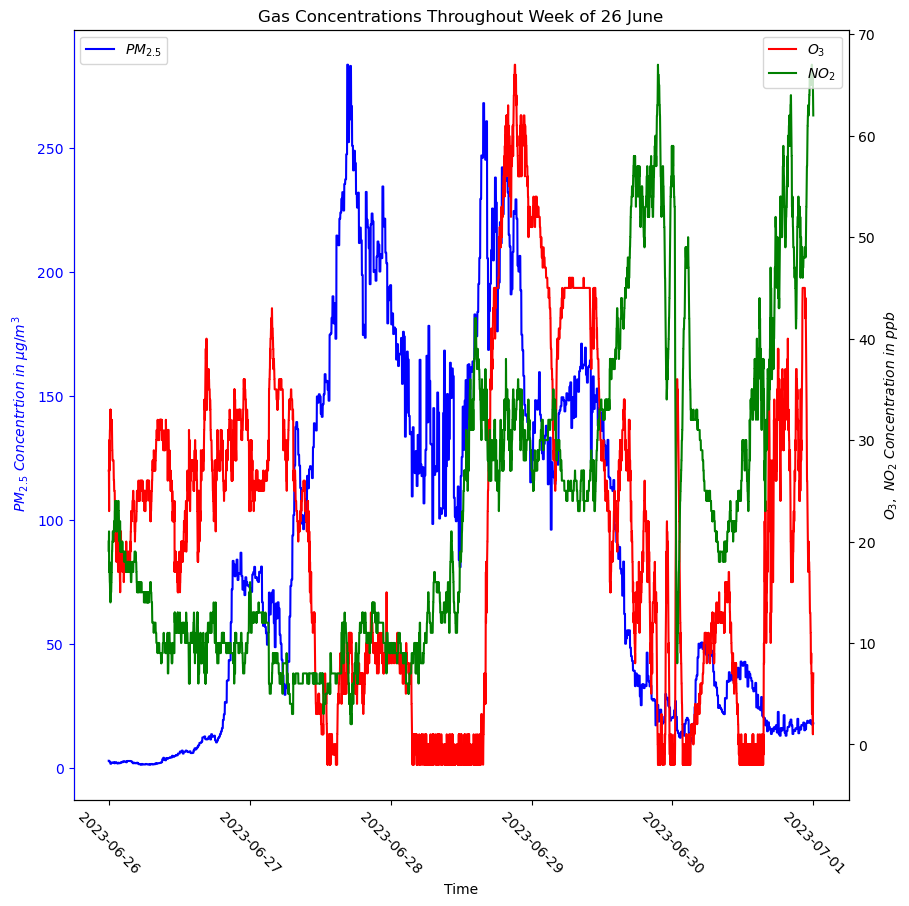

In [23]:
## Making a graph of PM2.5, Ozone, and NO2 throughout the Wildfire period. 
fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax1.plot(pm25["timestamp"], pm25["value"], color="Blue", label="$PM_{2.5}$")
plt.xticks(rotation=315)
plt.xlabel("Time")
plt.ylabel("$\ PM_{2.5}\ Concentrtion\ in\ \mu g/m^3$", color="blue")
plt.legend(loc=2)
ax1.tick_params(axis="y", colors="blue")
plt.title("Gas Concentrations Throughout Week of 26 June")

## Making a different axis for NO2 and O3, since they are in ppb and not micrograms/m^3
ax2 = ax1.twinx()
ax2.spines["left"].set_color("blue")
ax2.plot(o3["timestamp"], o3["value"]*1000, color="Red", label="$O_{3}$")
ax2.plot(no["timestamp"], no2["value"]*1000, color="Green", label="$NO_{2}$")
plt.ylabel("$O_{3},\ NO_{2}\ Concentration\ in\ ppb$")
plt.legend(loc=1)

plt.savefig("26_June_Gas_Concentrations", format='svg', bbox_inches='tight')

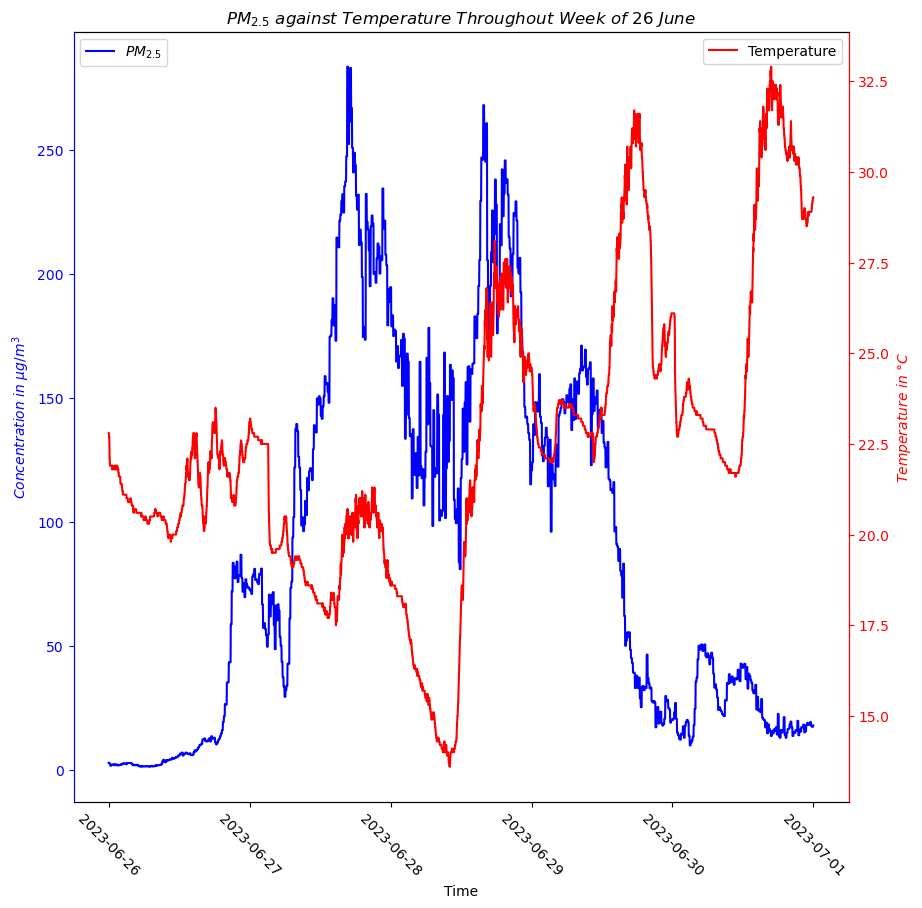

<Figure size 640x480 with 0 Axes>

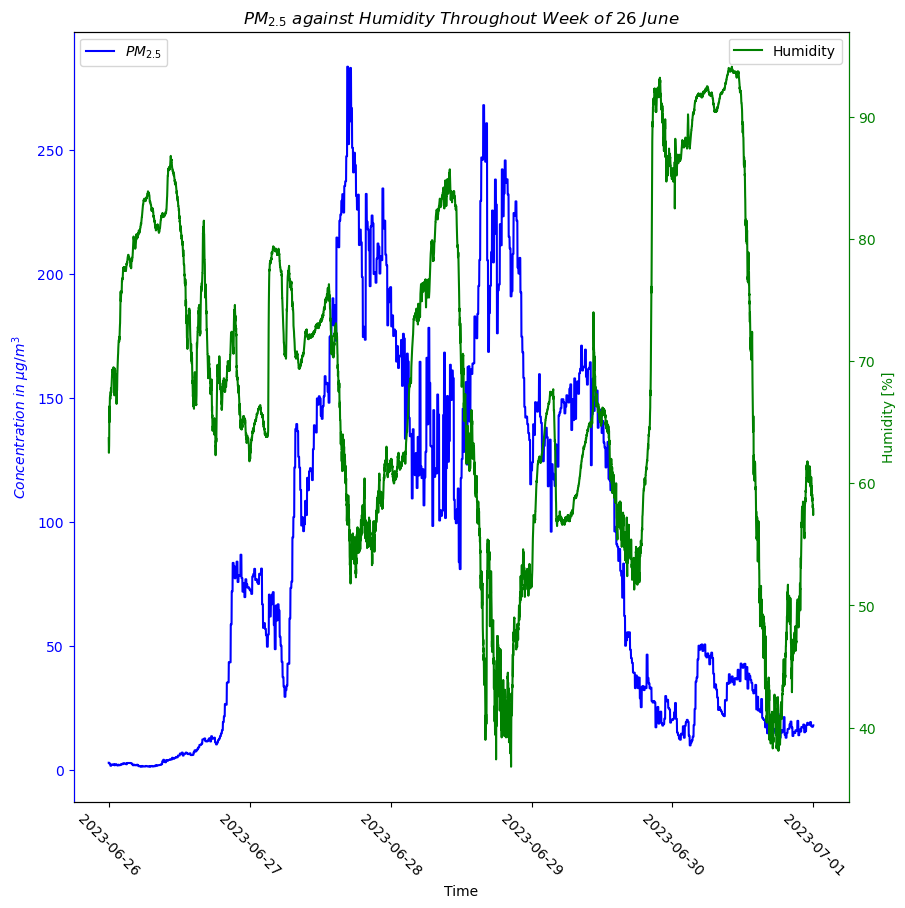

<Figure size 640x480 with 0 Axes>

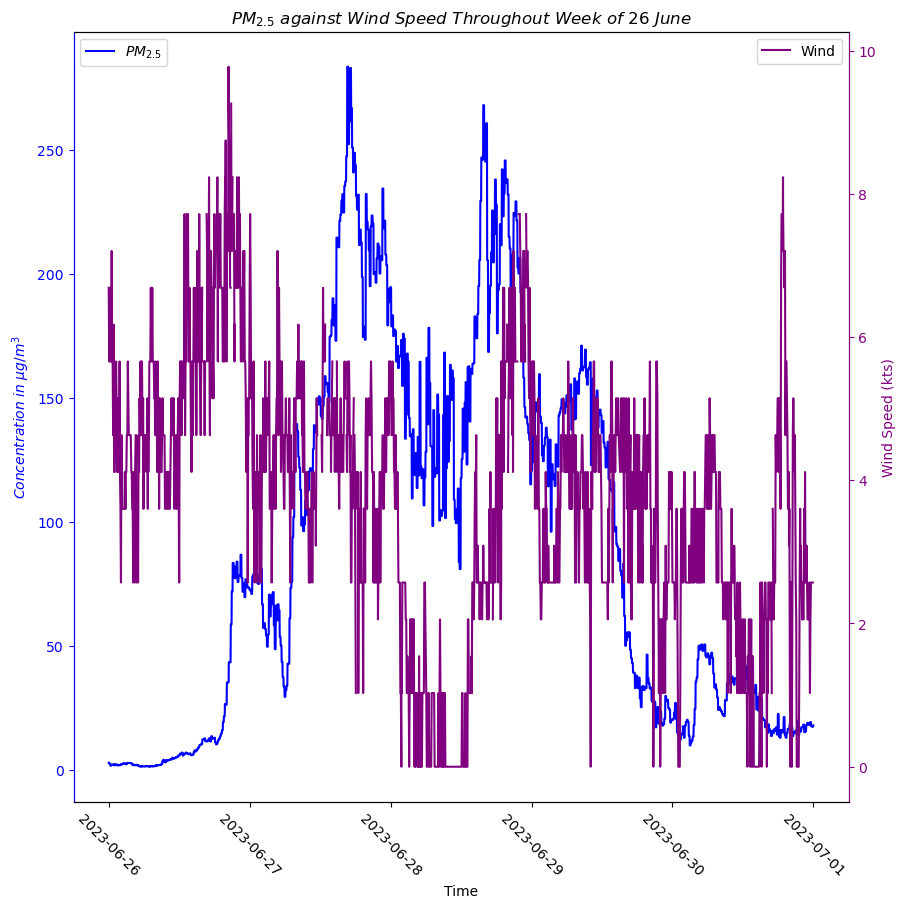

In [24]:
## Making cocnentrations of PM2.5 against various values

## This plot is of PM2.5 and temperature.
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
plt.plot(pm25["timestamp"], pm25["value"], color="Blue", label="$PM_{2.5}$")
plt.xticks(rotation=315)
plt.xlabel("Time")
plt.ylabel("$Concentration\ in\ \mu g/m^3$", color="Blue")
plt.legend(loc=2)
ax1.tick_params(axis="y", colors="blue")
plt.title("$PM_{2.5}\ against\ Temperature\ Throughout\ Week\ of\ 26\ June$")

## Making a different axis for temperature.
ax2 = ax1.twinx()
plt.plot(aqtemp["timestamp"], aqtemp["value"], color="Red", label="Temperature")
plt.legend(loc=1)
ax2.spines["left"].set_color("blue")
ax2.spines["right"].set_color("red")
ax2.tick_params(axis="y", colors="red")
plt.ylabel("$Temperature\ in\ \degree C$", color="red")
plt.savefig("26_June_Temperature_PM25", format='svg', bbox_inches='tight')

## This plot is of PM2.5 and Humidity
plt.figure()
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
plt.plot(pm25["timestamp"], pm25["value"], color="Blue", label="$PM_{2.5}$")
plt.xticks(rotation=315)
plt.xlabel("Time")
ax1.tick_params(axis="y", colors="blue")
plt.ylabel("$Concentration\ in\ \mu g/m^3$", color="blue")
plt.legend(loc=2)
plt.title("$PM_{2.5}\ against\ Humidity\ Throughout\ Week\ of\ 26\ June$")

## Making a different axis for humidity.
ax2 = ax1.twinx()
plt.plot(aqhum["timestamp"], aqhum["value"], color="Green", label="Humidity")
plt.legend(loc=1)
plt.ylabel("Humidity [%]", color="green")
ax2.spines["left"].set_color("blue")
ax2.spines["right"].set_color("green")
ax2.tick_params(axis="y", colors="green")
plt.savefig("26_June_Humidity_PM25", format='svg', bbox_inches='tight')

## This plot is of PM2.5 and Wind Speed.
plt.figure()
fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
plt.plot(pm25["timestamp"], pm25["value"], color="Blue", label="$PM_{2.5}$")
plt.xticks(rotation=315)
plt.xlabel("Time")
ax1.tick_params(axis="y", colors="blue")
plt.ylabel("$Concentration\ in\ \mu g/m^3$", color="blue")
plt.legend(loc=2)
plt.title("$PM_{2.5}\ against\ Wind\ Speed\ Throughout\ Week\ of\ 26\ June$")

## Making a different plot of PM2.5 and wind speed.
ax2 = ax1.twinx()
plt.plot(my_asoses["ORD"].time, wind_speed, color="Purple", label="Wind")
plt.legend(loc=1)
ax2.spines["left"].set_color("blue")
ax2.spines["right"].set_color("purple")
ax2.tick_params(axis="y", colors="purple")
plt.ylabel("Wind Speed (kts)", color="purple")
plt.savefig("26_June_Wind_Speed_PM25", format='svg', bbox_inches='tight')

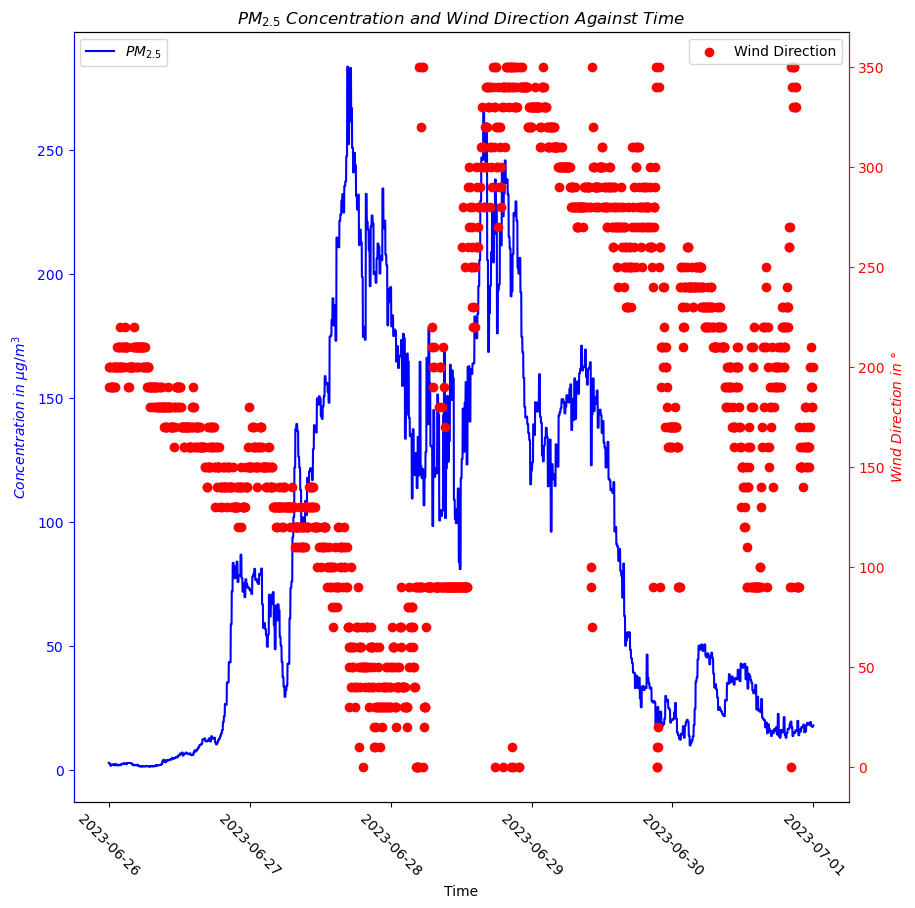

In [26]:
## Making a scatterplot of wind direction and PM2.5 Concentration 

## Since not every entry within that was taken at ASOS has a corresponding entry at NEIU, we need to filter them out and only
## take ASOS entries that have a corresponding entry at NEIU.
real_pm25 = []
counter = 0
time_array_1 = np.array(pm25["timestamp"])
pm_25 = np.array(pm25["value"])
time_array_2 = my_asoses["ORD"].time.values
## Goes through every entry that is contained within the ASOS data.
for j in range(len(time_array_2)):
    time1 = np.datetime64(time_array_2[j])
    ## Finds the time that is clostest to the next NEIU entry, and if this is the case, it appends this value of PM2.5 to a new 
    ## variable called PM2.5
    while True:
        time2 = np.datetime64(time_array_1[counter])
        if (time1 <= time2):
            real_pm25.append(pm_25[counter])
            break
        else:
            counter += 1

## Creates a scatterplot of wind direction and PM2.5 concentration.
fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
plt.plot(pm25["timestamp"], pm25["value"], color="Blue", label="$PM_{2.5}$")
plt.ylabel("$Concentration\ in\ \mu g/m^3$", color="blue")
plt.xticks(rotation=315)
plt.xlabel("Time")
ax1.tick_params(axis="y", colors="blue")
plt.title("$PM_{2.5}\ Concentration\ and\ Wind\ Direction\ Against\ Time$")
plt.legend(loc=2)

## Creates a different axis for wind direction
ax2 = ax1.twinx()
plt.scatter(time_array_2, wind_direction, label="Wind Direction", color="Red")
plt.ylabel("$Wind\ Direction\ in\ \degree$", color="red")
plt.legend(loc=1)
ax2.spines["left"].set_color("blue")
ax2.spines["right"].set_color("red")
ax2.tick_params(axis="y", colors="red")
plt.savefig("26_June_Wind_Direction_PM25", format='svg', bbox_inches='tight')

In [28]:
## Makes an np array of pm2.5 values (much easier to work with)
pm25_new = np.array(pm25.value.values)

In [98]:
len(time_array)

1115

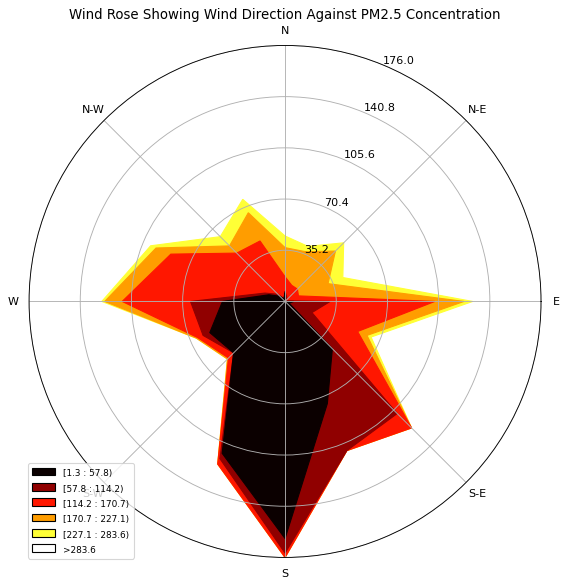

In [49]:
## Let's make a windrose from the built in WindroseAxes plot.
ax = WindroseAxes.from_ax()
ax.contourf(wind_direction, real_pm25, cmap=cm.hot)
ax.set_legend()
plt.title("Wind Rose Showing Wind Direction Against PM2.5 Concentration")
plt.savefig("pm25_windrose")

['C:/Users/jacob/air-quality-sensors/notebooks/CMS_wxt536_NEIU_a1_20230626_000000Z.nc', 'C:/Users/jacob/air-quality-sensors/notebooks/CMS_wxt536_NEIU_a1_20230627_000000Z.nc', 'C:/Users/jacob/air-quality-sensors/notebooks/CMS_wxt536_NEIU_a1_20230628_000000Z.nc', 'C:/Users/jacob/air-quality-sensors/notebooks/CMS_wxt536_NEIU_a1_20230629_000000Z.nc', 'C:/Users/jacob/air-quality-sensors/notebooks/CMS_wxt536_NEIU_a1_20230630_000000Z.nc']


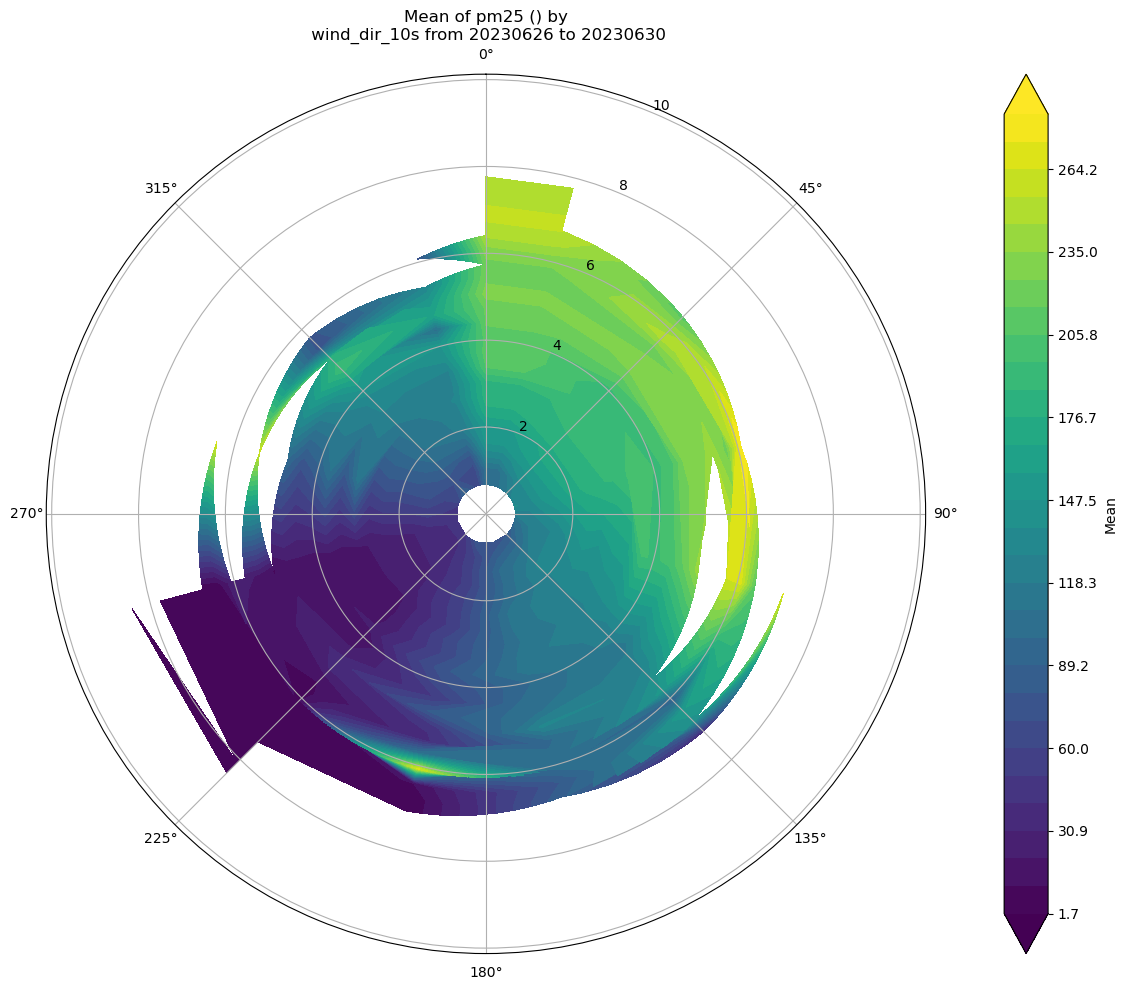

In [29]:
## Let's make an ACT windrose from 26-30 June data. Use this windrose for the final project. 
array = []
wind_direction = np.empty(0)
## Import in the datafiles from my computer. These are the ingested WXT files created from Scott Collis. 
for i in range (26, 31):
    fn = 'C:/Users/jacob/air-quality-sensors/notebooks/CMS_wxt536_NEIU_a1_202306%d_000000Z.nc' % i
    array.append(fn)
print(array)
## Use the built in ACT reader system to bring in the files.
ds = act.io.armfiles.read_netcdf(array)
new_pm25 = []
counter = -1
## Taking every entry that is within PM2.5 and multiplying it by 6. This is because PM2.5 is recorded every minute, while wind
## speed is recorded every ten seconds, and since 60/10 = 6, we are adding 6 entries for every entry of PM2.5
for i in range(len(pm25)*6):
    if (i % 6 == 0):
        counter += 1
        new_pm25.append(pm25_new[counter])
    else:
        new_pm25.append(pm25_new[counter])
ds["pm25"] = new_pm25
## Actually creating the wind rose.
display = act.plotting.WindRoseDisplay(ds, figsize=(16,10))
display.plot_data(
    'wind_dir_10s',
    'wind_mean_10s',
    'pm25',
    num_dirs=12,
    plot_type='contour',
    contour_type='mean',
    cbar_kwargs={'label': "Mean Concentration of PM2.5"}
)
plt.savefig("windrose_pm25_wildfire", format='svg', bbox_inches='tight')

<class 'xarray.core.dataset.Dataset'>


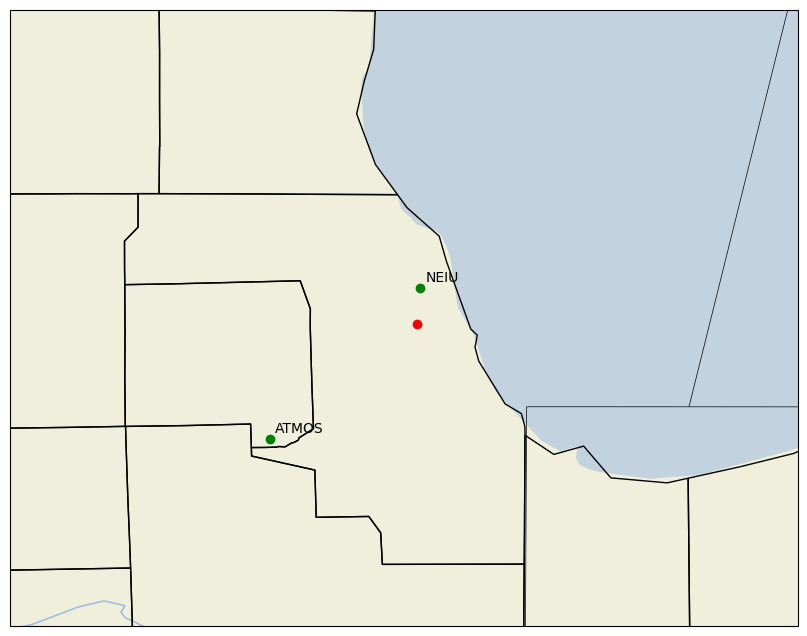

In [30]:
## Assessing Waggle Node at NEIU
## Making a graph of one station that is located clostest to ATMOS

# You need an account and token from https://docs.airnowapi.org/ first
token = "D7EB47D8-30DA-4E6C-AB31-3EAB5C2E78D3"

if token is not None and len(token) > 0:
    # This first example will get the forcasted values for the date passed
    # at stations within 100 miles of the Zipcode. Can also use latlon instead as
    # results = act.discovery.get_airnow_forecast(token, '2022-05-01', distance=100,
    #                                             latlon=[41.958, -88.12])
    # If the username and token are not set, use the existing sample file
    results = act.discovery.get_airnow_forecast(token, '2022-05-01', zipcode=60439, distance=100)

    # The results show a dataset with air quality information from Oklahoma City
    # The data is not indexed by time and just a rudimentary xarray object from
    # converted from a pandas DataFrame.  Note that the AirNow API labels the data
    # returned as AQI.
    # print(results)
    print(type(results))

    # This call gives the daily average for Ozone, PM2.5 and PM10
    results = act.discovery.get_airnow_obs(token, date='2023-05-24', zipcode=60439, distance=100)
    # print(results)
    # print(type(results))

    # This call will get all the station data for a time period within
    # the bounding box provided.  This will return the object with time
    # as a coordinate and can be used with ACT Plotting to plot after
    # squeezing the dimensions.  It can be a 2D time series
    lat_lon = '-87.76703552,41.880289109,-87.61703552,42.030289109'
    results = act.discovery.get_airnow_bounded_obs(
        token, '2023-06-26T00', '2023-07-01T00', lat_lon, 'OZONE,PM25', data_type='B'
    )
    # Reduce to 1D timeseries

    ## Let's make the figure
    plt.figure(figsize=(15,8))
    ax = plt.axes(projection=ccrs.PlateCarree());
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN);
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS);
    ax.add_feature(cfeature.BORDERS, linestyle=':');
    ax.coastlines(color='gray',resolution='110m');
    ax.set_extent([-88.474769, -87.020042, 41.356063,42.493302])
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',  name='admin_1_states_provinces_lines',
            scale='50m', linewidth=0.5, facecolor='none')

    ax.add_feature(states_provinces, zorder=10);
    ax.scatter(results.longitude, results.latitude, color="red", transform=ccrs.PlateCarree())
    ax.add_feature(USCOUNTIES)
    WAGGLE_SITES = {'NEIU'  : [41.980289109, -87.71703552],
                'ATMOS' : [41.701605152, -87.995196552]
               }
    ax.plot(WAGGLE_SITES["ATMOS"][1], WAGGLE_SITES["ATMOS"][0], color="Green", marker="o", transform=ccrs.PlateCarree())
    ax.text(WAGGLE_SITES["ATMOS"][1]+0.01, WAGGLE_SITES["ATMOS"][0]+0.01, "ATMOS", color="Black", transform=ccrs.PlateCarree())
    ax.plot(WAGGLE_SITES["NEIU"][1], WAGGLE_SITES["NEIU"][0], color="Green", marker="o", transform=ccrs.PlateCarree())
    ax.text(WAGGLE_SITES["NEIU"][1]+0.01, WAGGLE_SITES["NEIU"][0]+0.01, "NEIU", color="Black", transform=ccrs.PlateCarree())

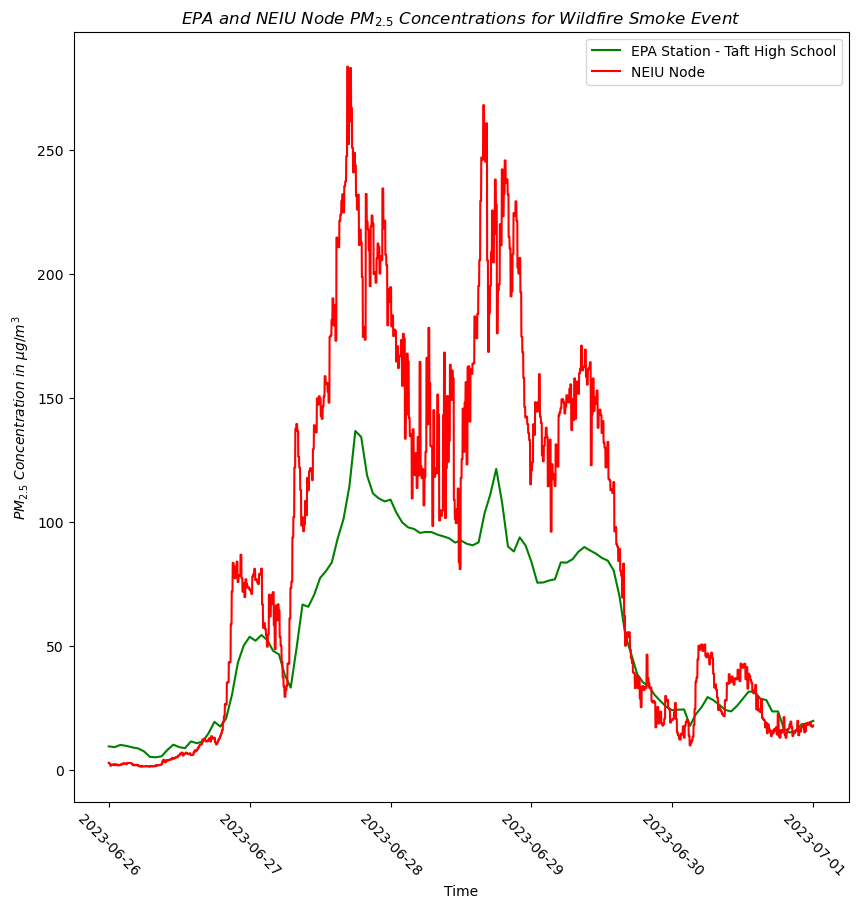

In [31]:
## Plotting the EPA dataset against the waggle node dataset.
plt.figure(figsize=(10,10))
plt.plot(results.time, results["PM2.5"], color="green", label="EPA Station - Taft High School")
plt.plot(pm25["timestamp"], pm25["value"], color="red", label="NEIU Node")
plt.ylabel("$ PM_{2.5}\ Concentration\ in\ \mu g/m^3$")
plt.xlabel('Time')
plt.title("$EPA\ and\ NEIU\ Node\ PM_{2.5}\ Concentrations\ for\ Wildfire\ Smoke\ Event$") 
plt.xticks(rotation=315)
plt.legend()
plt.savefig("EPA_NEIU_wildfire", format='svg', bbox_inches='tight')